# EMG特征提取实践 - 深度教学版

## 📚 课程目标

### 知识目标
1. 理解EMG信号的**生理学基础**和信号特性
2. 掌握18种经典特征的**数学原理**和**物理意义**
3. 学会选择合适的特征用于不同的应用场景
4. 理解特征工程在机器学习中的关键作用

### 技能目标
1. 能够从原始EMG信号中提取18种特征
2. 能够分析特征的统计特性和相关性
3. 能够根据应用需求选择最优特征组合
4. 能够评估特征的区分能力

## 🧠 EMG信号的生理学基础

### 什么是EMG（肌电图）？
**EMG (Electromyography)** 是记录肌肉电活动的技术。当大脑发出运动指令时：

```
大脑皮层 → 脊髓 → 运动神经元 → 肌纤维 → 肌肉收缩
            ↓
         EMG信号（可以被电极检测到）
```

### EMG信号的组成
1. **运动单元动作电位 (MUAP)**
   - 单个运动单元（一个神经元+它支配的肌纤维）的电活动
   - 持续时间：5-15 ms
   - 幅度：50 µV - 5 mV

2. **叠加效应**
   - EMG = 多个MUAP的时空叠加
   - 收缩越强 → 激活的运动单元越多 → EMG幅度越大

3. **频率特性**
   - 主要能量：20-500 Hz
   - 峰值频率：50-150 Hz（取决于肌肉类型和收缩强度）

### EMG信号的影响因素

| 因素 | 影响 | 举例 |
|------|------|------|
| **肌肉类型** | 快肌纤维频率更高 | 手指肌肉 vs 背部肌肉 |
| **收缩强度** | 强度↑ → 幅度↑、频率↑ | 轻握 vs 用力握拳 |
| **疲劳程度** | 疲劳↑ → 幅度↓、频率↓ | 持续收缩时MDF下降 |
| **电极位置** | 离肌肉越近信号越强 | 表面EMG vs 针极EMG |
| **皮下脂肪** | 脂肪层↑ → 信号衰减 | 肥胖患者信号更弱 |

## 🎯 为什么需要特征提取？

### 原始信号 vs 特征

```
原始EMG信号（5秒，1000Hz）
    ↓ [5000个数据点，难以直接用于分类]
特征提取
    ↓ [18个数值，高度浓缩的信息]
机器学习分类器
    ↓
识别结果（如：握拳、张开、静息）
```

### 特征的作用
1. **降维**：5000个点 → 18个特征（降维99.6%）
2. **去噪**：统计特征对噪声更鲁棒
3. **可解释性**：MAV大 → 肌肉收缩强
4. **提高效率**：特征计算比原始信号分类快得多

## 📖 本节学习路线图

```
第1步: 信号预处理（去噪、滤波）
        ↓
第2步: 时域特征（10种）
        ├─ 幅度特征：MAV, RMS, PEAK
        ├─ 变化特征：VAR, WL, DASDV
        └─ 频率估计：ZC, SSC
        ↓
第3步: 频域特征（8种）
        ├─ 频率特征：MNF, MDF, Peak_Freq
        ├─ 能量特征：Total_Power
        └─ 高阶特征：SM1-3, Freq_Ratio
        ↓
第4步: 滑动窗口（实时应用）
        ↓
第5步: 特征分析与选择
```

## 💡 实际应用场景

### 1. 康复医学
- **评估肌肉功能**：通过MAV/RMS评估肌力
- **监测康复进度**：训练前后特征对比
- **疲劳检测**：MDF下降表示肌肉疲劳

### 2. 假肢控制
- **手势识别**：识别握拳、张开、捏取等动作
- **力度控制**：MAV/RMS → 假肢抓取力度
- **实时响应**：使用快速的时域特征

### 3. 人机交互
- **虚拟现实**：EMG控制游戏角色
- **手势鼠标**：用肌肉信号控制电脑
- **无接触界面**：适用于医疗、工业环境

### 4. 运动科学
- **技术分析**：评估运动员肌肉激活模式
- **训练优化**：监测训练强度和疲劳
- **损伤预防**：异常EMG模式预警

---

## 🚀 开始实践

让我们从信号采集和预处理开始...

In [1]:
# ===== 导入必要的Python库 =====

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# ===== 添加项目路径（改进版，解决导入问题） =====
# 获取项目根目录
project_root = Path.cwd().parent
if not (project_root / 'code').exists():
    project_root = Path.cwd()

print(f"项目根目录: {project_root}")
print(f"code目录存在: {(project_root / 'code').exists()}")

# 清理sys.path中的旧路径，避免冲突
sys.path = [p for p in sys.path if 'EMG_Learning_Project' not in p]

# 添加项目根目录到sys.path的最前面
sys.path.insert(0, str(project_root))

# --- Jupyter/IPython 兼容性修复 ---
# IPython 往往会先导入标准库的 `code` 模块，导致 `code.weekXX_*` 不是包。
# 这里把项目的 `code/` 目录挂到 `code.__path__`，让子模块可被正常导入。
import code as _code
if not hasattr(_code, '__path__'):
    _code.__path__ = [str(project_root / 'code')]

print(f"sys.path[0]: {sys.path[0]}")

# ===== 导入自定义模块（使用importlib确保重新加载） =====
import importlib

try:
    # 方法1: 尝试直接导入
    from code.week06_preprocessing.filters import EMGFilters
    from code.week07_feature_extraction.features import EMGFeatures
    print("✓ 模块导入成功（方法1）！")
    
except ImportError as e1:
    print(f"方法1失败: {e1}")
    
    try:
        # 方法2: 使用importlib动态导入
        print("\n尝试方法2: 使用importlib...")
        
        # 导入filters模块
        filters_module = importlib.import_module('code.week06_preprocessing.filters')
        EMGFilters = filters_module.EMGFilters
        
        # 导入features模块
        features_module = importlib.import_module('code.week07_feature_extraction.features')
        EMGFeatures = features_module.EMGFeatures
        
        print("✓ 模块导入成功（方法2）！")
        
    except Exception as e2:
        print(f"\n方法2也失败: {e2}")
        print("\n最后尝试：直接添加模块路径...")
        
        # 方法3: 直接添加模块目录到sys.path
        sys.path.insert(0, str(project_root / 'code' / 'week06_preprocessing'))
        sys.path.insert(0, str(project_root / 'code' / 'week07_feature_extraction'))
        
        try:
            from filters import EMGFilters
            from features import EMGFeatures
            print("✓ 模块导入成功（方法3）！")
        except Exception as e3:
            print(f"✗ 所有方法都失败: {e3}")
            print("\n请联系助教或老师获取帮助")
            raise

# ===== 配置matplotlib中文显示 =====
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Segoe UI Symbol', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("\n✓ 环境配置完成！")

项目根目录: c:\Users\Administrator\EMG_Learning_Project
code目录存在: True
sys.path[0]: c:\Users\Administrator\EMG_Learning_Project
✓ 模块导入成功（方法1）！

✓ 环境配置完成！


## 1. 生成并预处理EMG信号

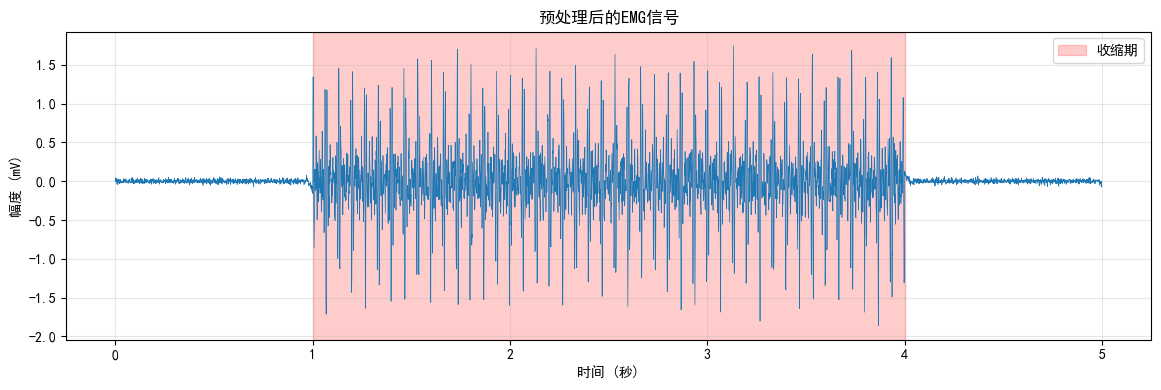

✓ 信号准备完成


In [2]:
fs = 1000
duration = 5
t = np.linspace(0, duration, int(duration * fs))

# 生成EMG信号
signal = np.random.normal(0, 0.02, len(t))
contraction_start = int(1 * fs)
contraction_end = int(4 * fs)

for freq in range(70, 140, 15):
    signal[contraction_start:contraction_end] += 0.3 * np.sin(
        2 * np.pi * freq * t[contraction_start:contraction_end]
    )
signal[contraction_start:contraction_end] += np.random.normal(0, 0.15, contraction_end - contraction_start)

# 预处理
filters = EMGFilters(fs=fs)
signal_filtered = filters.preprocess_emg(signal, remove_powerline=True)

plt.figure(figsize=(14, 4))
plt.plot(t, signal_filtered, linewidth=0.5)
plt.axvspan(1, 4, alpha=0.2, color='red', label='收缩期')
plt.xlabel('时间 (秒)')
plt.ylabel('幅度 (mV)')
plt.title('预处理后的EMG信号')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("✓ 信号准备完成")

## 2. 提取时域特征

时域特征直接从信号波形计算，反映信号的幅度和变化特性。

时域特征：

MAV       :   0.345074
RMS       :   0.495790
VAR       :   0.245808
WL        : 814.726824
ZC        : 820.000000
SSC       : 965.000000
IEMG      : 1035.221048
DASDV     :   0.361597
PEAK      :   1.861628
MEAN      :  -0.000010


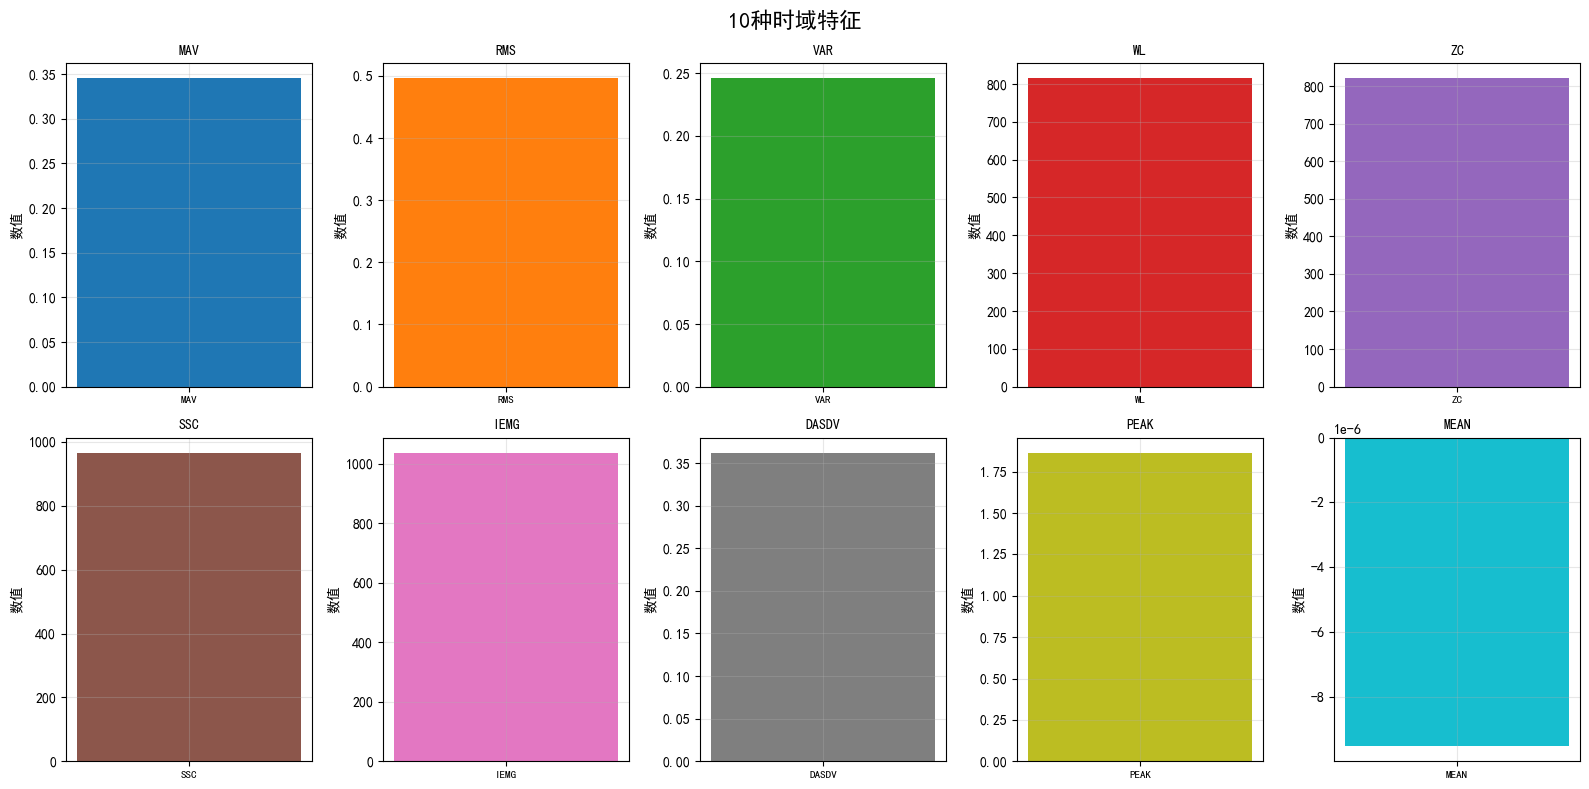

In [3]:
# 提取收缩期的时域特征
contraction_signal = signal_filtered[contraction_start:contraction_end]
time_features = EMGFeatures.extract_time_features(contraction_signal)

print("时域特征：\n")
for name, value in time_features.items():
    print(f"{name:10s}: {value:10.6f}")

# 可视化时域特征
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
fig.suptitle('10种时域特征', fontsize=16, fontweight='bold')

features_list = list(time_features.items())
for idx, (name, value) in enumerate(features_list):
    row = idx // 5
    col = idx % 5
    
    axes[row, col].bar([name], [value], color=f'C{idx}')
    axes[row, col].set_title(name, fontsize=10)
    axes[row, col].set_ylabel('数值')
    axes[row, col].tick_params(axis='x', labelsize=8)
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 时域特征说明

- **MAV** (Mean Absolute Value): 平均绝对值，反映肌肉激活程度
- **RMS** (Root Mean Square): 均方根，常用的幅度指标
- **VAR** (Variance): 方差，反映信号波动程度
- **WL** (Waveform Length): 波形长度，反映信号复杂度
- **ZC** (Zero Crossing): 过零率，反映频率特性
- **SSC** (Slope Sign Change): 斜率符号变化，反映信号频率
- **IEMG** (Integrated EMG): 积分EMG
- **DASDV** (Difference Absolute Standard Deviation Value): 差分绝对标准差
- **PEAK**: 峰值
- **MEAN**: 均值

## 3. 提取频域特征

频域特征通过傅里叶变换计算，反映信号的频率分布。

频域特征：

MNF            : 112.644160
MDF            : 100.000000
Peak_Freq      : 100.000000
Total_Power    :   0.491615
SM1            : 112.644160
SM2            : 16232.694159
SM3            : 3398789.411692
Freq_Ratio     :   1.559076


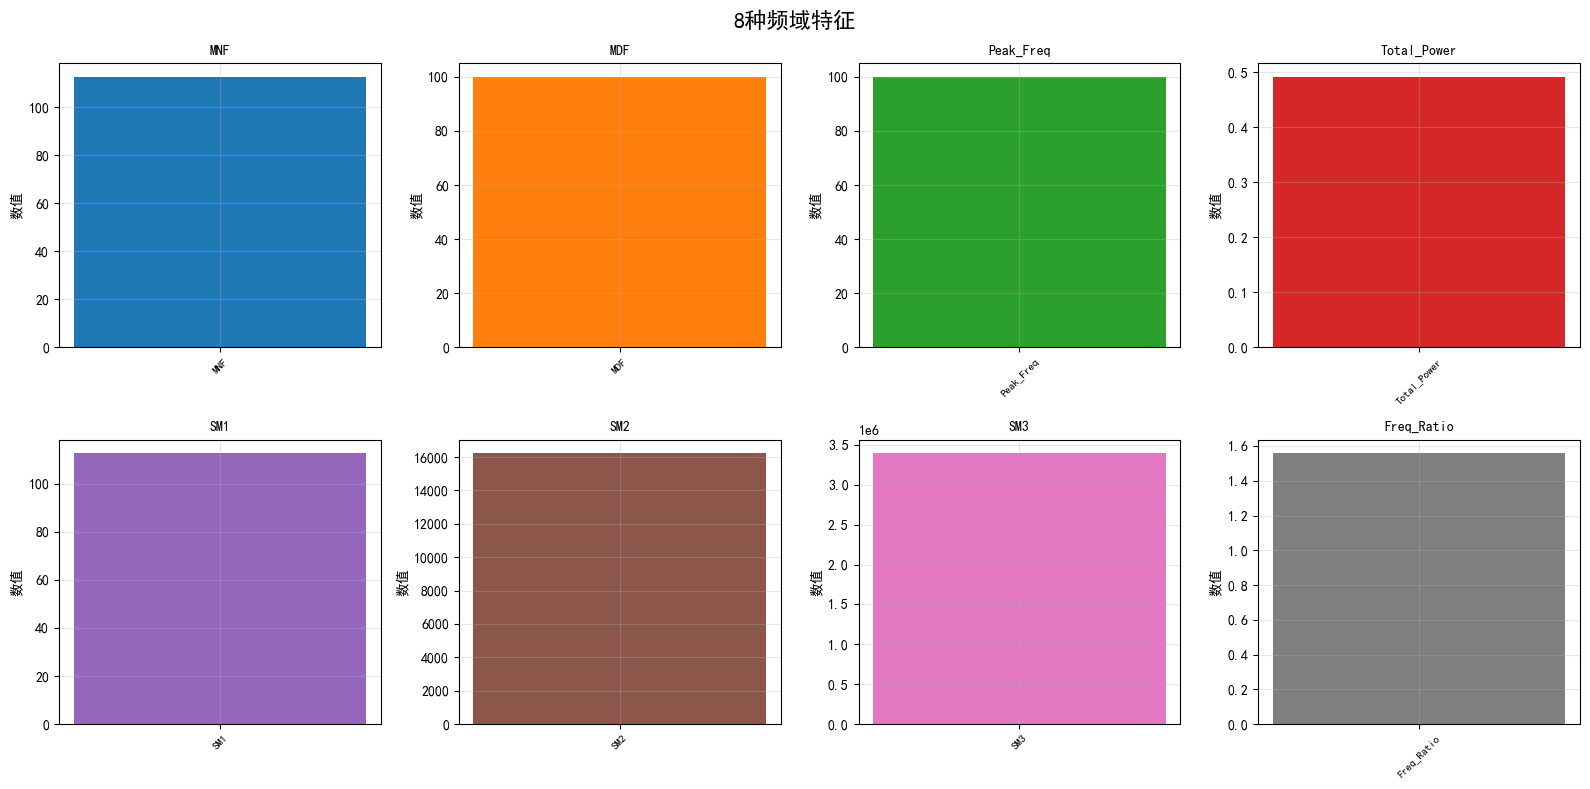

In [4]:
# 提取频域特征
freq_features = EMGFeatures.extract_freq_features(contraction_signal, fs=fs)

print("频域特征：\n")
for name, value in freq_features.items():
    print(f"{name:15s}: {value:10.6f}")

# 可视化频域特征
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('8种频域特征', fontsize=16, fontweight='bold')

features_list = list(freq_features.items())
for idx, (name, value) in enumerate(features_list):
    row = idx // 4
    col = idx % 4
    
    axes[row, col].bar([name], [value], color=f'C{idx}')
    axes[row, col].set_title(name, fontsize=10)
    axes[row, col].set_ylabel('数值')
    axes[row, col].tick_params(axis='x', labelsize=8, rotation=45)
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 频域特征说明

- **MNF** (Mean Frequency): 平均频率
- **MDF** (Median Frequency): 中值频率
- **Peak_Freq**: 峰值频率，功率最大的频率
- **Total_Power**: 总功率
- **SM1**: 频谱矩1阶
- **SM2**: 频谱矩2阶
- **SM3**: 频谱矩3阶
- **Freq_Ratio**: 频率比

## 4. 滑动窗口特征提取

在实际应用中，我们通常使用滑动窗口来提取特征，以捕捉信号随时间的变化。

In [5]:
# 滑动窗口特征提取
window_size = 200  # 200ms窗口
step = 100  # 100ms步长

features, feature_names, time_points = EMGFeatures.sliding_window_features(
    signal_filtered,
    window_size=window_size,
    step=step,
    fs=fs,
    include_time=True,
    include_freq=True
)

print(f"✓ 滑动窗口特征提取完成")
print(f"  特征矩阵形状: {features.shape}")
print(f"  窗口数: {len(time_points)}")
print(f"  特征数: {len(feature_names)}")
print(f"\n特征名称: {feature_names[:5]}...")

✓ 滑动窗口特征提取完成
  特征矩阵形状: (49, 18)
  窗口数: 49
  特征数: 18

特征名称: ['MAV', 'RMS', 'VAR', 'WL', 'ZC']...


## 5. 特征随时间变化的可视化

观察关键特征在静息期和收缩期的变化。

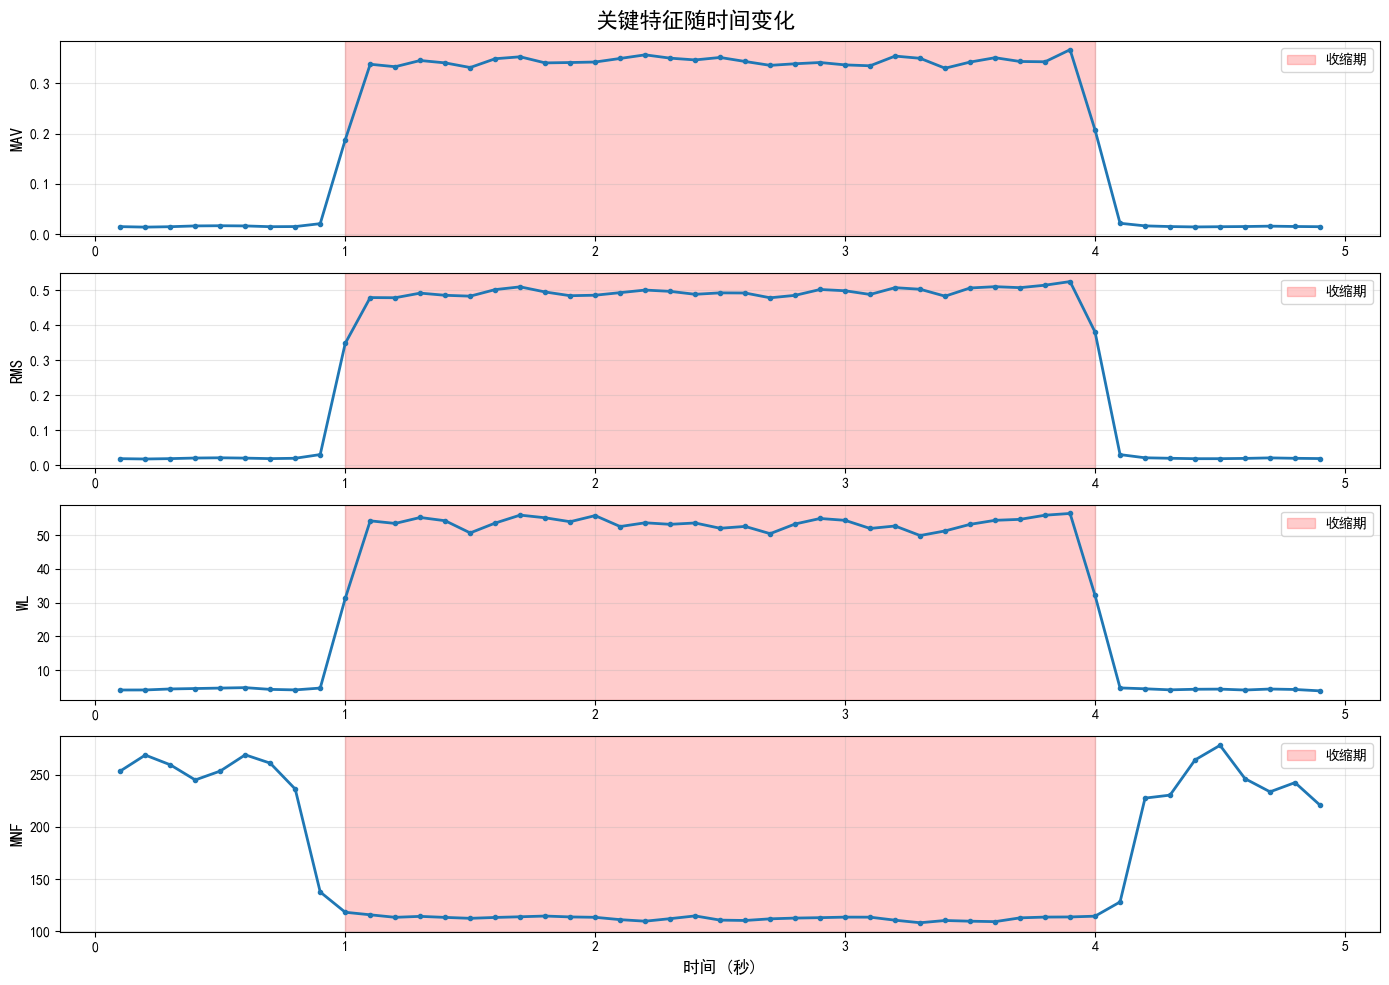

观察:
  - MAV和RMS在收缩期显著增大
  - WL（波形长度）也在收缩期增加
  - MNF（平均频率）可能有轻微变化


In [6]:
# 选择几个关键特征进行可视化
key_features = ['MAV', 'RMS', 'WL', 'MNF']
key_indices = [feature_names.index(f) for f in key_features if f in feature_names]

fig, axes = plt.subplots(len(key_indices), 1, figsize=(14, 10))
fig.suptitle('关键特征随时间变化', fontsize=16, fontweight='bold')

for idx, (feat_idx, feat_name) in enumerate(zip(key_indices, key_features)):
    axes[idx].plot(time_points, features[:, feat_idx], linewidth=2, marker='o', markersize=3)
    axes[idx].axvspan(1, 4, alpha=0.2, color='red', label='收缩期')
    axes[idx].set_ylabel(feat_name, fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

axes[-1].set_xlabel('时间 (秒)', fontsize=12)
plt.tight_layout()
plt.show()

print("观察:")
print("  - MAV和RMS在收缩期显著增大")
print("  - WL（波形长度）也在收缩期增加")
print("  - MNF（平均频率）可能有轻微变化")

## 6. 不同手势的特征对比

生成三种不同的模拟手势，对比它们的特征。

In [7]:
# 生成三种不同强度的手势
gestures = {
    'rest': 0.0,
    'weak': 0.3,
    'strong': 0.6
}

gesture_features = {}

for gesture_name, intensity in gestures.items():
    # 生成信号
    sig = np.random.normal(0, 0.02, 1000)
    if intensity > 0:
        for freq in range(70, 140, 15):
            sig += intensity * np.sin(2 * np.pi * freq * np.linspace(0, 1, 1000))
        sig += np.random.normal(0, intensity * 0.1, 1000)
    
    # 提取特征
    time_feat = EMGFeatures.extract_time_features(sig)
    freq_feat = EMGFeatures.extract_freq_features(sig, fs=1000)
    
    gesture_features[gesture_name] = {**time_feat, **freq_feat}

# 转换为DataFrame方便可视化
df = pd.DataFrame(gesture_features).T

print("不同手势的特征对比:\n")
print(df[['MAV', 'RMS', 'WL', 'MNF']].round(4))

不同手势的特征对比:

           MAV     RMS        WL       MNF
rest    0.0160  0.0201   23.1439  247.8467
weak    0.3160  0.4740  211.0042  100.9697
strong  0.6294  0.9484  415.0420  100.4454


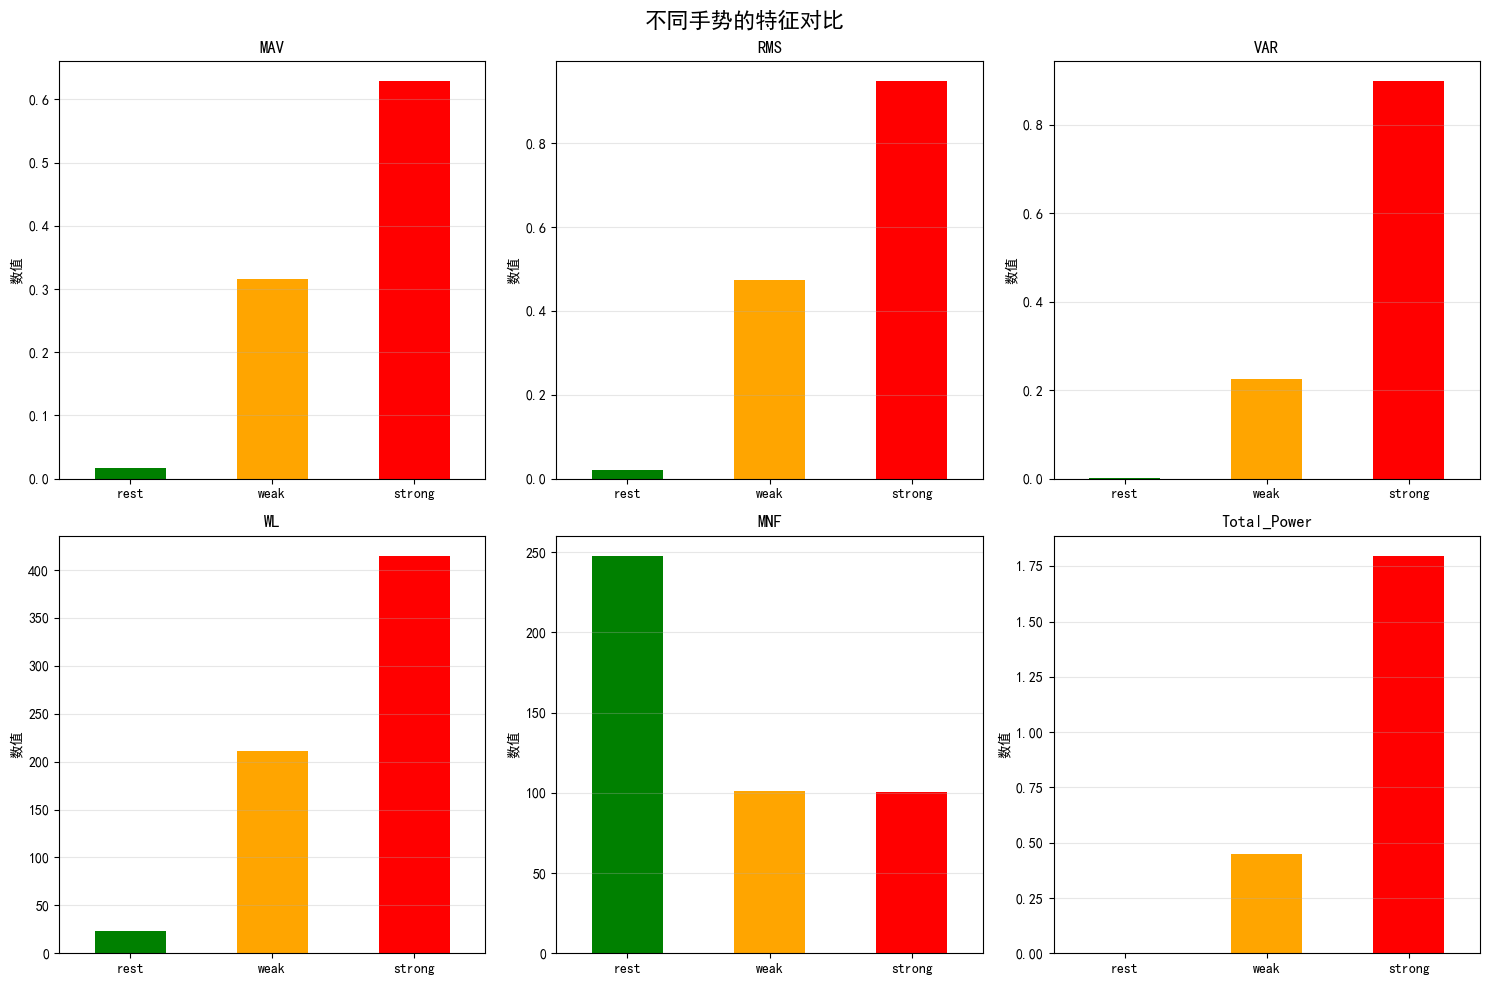

In [8]:
# 可视化特征对比
selected_features = ['MAV', 'RMS', 'VAR', 'WL', 'MNF', 'Total_Power']
df_selected = df[selected_features]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('不同手势的特征对比', fontsize=16, fontweight='bold')

for idx, feat in enumerate(selected_features):
    row = idx // 3
    col = idx % 3
    
    df_selected[feat].plot(kind='bar', ax=axes[row, col], color=['green', 'orange', 'red'])
    axes[row, col].set_title(feat, fontsize=12)
    axes[row, col].set_ylabel('数值')
    axes[row, col].set_xlabel('')
    axes[row, col].tick_params(axis='x', rotation=0)
    axes[row, col].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. 特征相关性分析

分析不同特征之间的相关性，有助于特征选择。

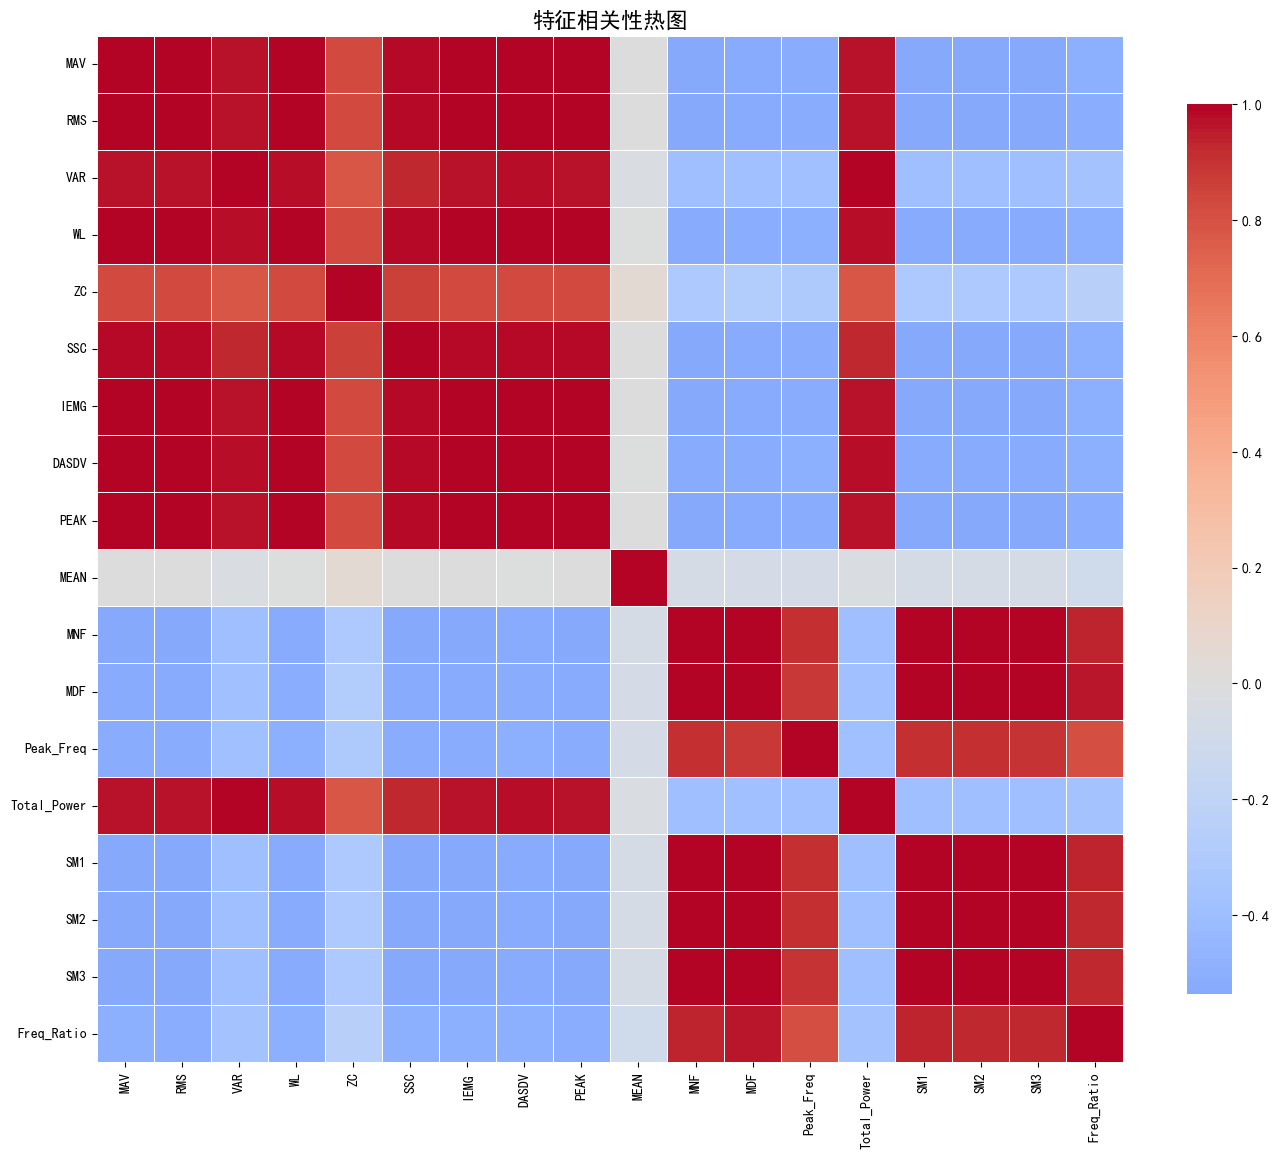

高度相关的特征对（|相关系数| > 0.9）：

  MAV        <-> RMS       : 1.000
  MAV        <-> VAR       : 0.974
  MAV        <-> WL        : 1.000
  MAV        <-> SSC       : 0.986
  MAV        <-> IEMG      : 1.000
  MAV        <-> DASDV     : 1.000
  MAV        <-> PEAK      : 1.000
  MAV        <-> Total_Power: 0.974
  RMS        <-> VAR       : 0.974
  RMS        <-> WL        : 1.000


In [9]:
# 生成多个样本来计算相关性
n_samples = 50
feature_matrix = []

for _ in range(n_samples):
    intensity = np.random.uniform(0, 0.8)
    sig = np.random.normal(0, 0.02, 1000)
    
    if intensity > 0.1:
        for freq in range(70, 140, 15):
            sig += intensity * np.sin(2 * np.pi * freq * np.linspace(0, 1, 1000))
        sig += np.random.normal(0, intensity * 0.1, 1000)
    
    time_feat = EMGFeatures.extract_time_features(sig)
    freq_feat = EMGFeatures.extract_freq_features(sig, fs=1000)
    
    all_feat = {**time_feat, **freq_feat}
    feature_matrix.append(list(all_feat.values()))

# 创建DataFrame
df_features = pd.DataFrame(feature_matrix, columns=list(all_feat.keys()))

# 计算相关性矩阵
corr_matrix = df_features.corr()

# 可视化相关性热图
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('特征相关性热图', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("高度相关的特征对（|相关系数| > 0.9）：\n")
high_corr = []
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr.append((corr_matrix.index[i], corr_matrix.columns[j], 
                            corr_matrix.iloc[i, j]))

for feat1, feat2, corr in high_corr[:10]:  # 显示前10个
    print(f"  {feat1:10s} <-> {feat2:10s}: {corr:.3f}")

## 8. 特征选择建议

基于相关性分析，选择最有代表性的特征。

In [10]:
# 计算特征的方差（方差越大，信息量越大）
feature_variance = df_features.var().sort_values(ascending=False)

print("特征方差排序（方差越大，变化越明显）：\n")
for feat, var in feature_variance.head(10).items():
    print(f"  {feat:15s}: {var:.6f}")

# 推荐的特征组合
print("\n推荐的特征组合：")
print("\n基础组合（快速分类）：")
print("  - MAV, RMS, WL")
print("\n标准组合（平衡性能）：")
print("  - MAV, RMS, VAR, WL, ZC, SSC")
print("\n完整组合（最佳性能）：")
print("  - 所有18种特征")
print("\n注意：更多特征不一定更好，需要通过实验验证。")

特征方差排序（方差越大，变化越明显）：

  SM3            : 60630212033093.867188
  SM2            : 357101585.185552
  IEMG           : 64627.201086
  WL             : 27830.616496
  SSC            : 6081.233061
  MNF            : 1518.649935
  SM1            : 1518.649935
  MDF            : 1430.673061
  Peak_Freq      : 780.613878
  ZC             : 303.739184

推荐的特征组合：

基础组合（快速分类）：
  - MAV, RMS, WL

标准组合（平衡性能）：
  - MAV, RMS, VAR, WL, ZC, SSC

完整组合（最佳性能）：
  - 所有18种特征

注意：更多特征不一定更好，需要通过实验验证。


## 9. 实战：处理真实数据（可选）

In [11]:
try:
    from code.week05_data_processing.data_loading import EMGDataLoader
    
    loader = EMGDataLoader(data_dir='../data/sample/', fs=1000)
    
    # 加载三种手势的数据
    gestures_real = ['rest', 'fist', 'open']
    real_features = {}
    
    for gesture in gestures_real:
        try:
            time_real, signals_real, label = loader.load_single_trial(
                f'../data/sample/subject_01/{gesture}/trial_001.csv'
            )
            
            # 提取第一个通道的特征
            ch0 = signals_real[:, 0]
            ch0_filtered = filters.preprocess_emg(ch0)
            
            time_feat = EMGFeatures.extract_time_features(ch0_filtered)
            freq_feat = EMGFeatures.extract_freq_features(ch0_filtered, fs=1000)
            
            real_features[gesture] = {**time_feat, **freq_feat}
        except:
            pass
    
    if real_features:
        df_real = pd.DataFrame(real_features).T
        
        print("真实数据的特征对比:\n")
        print(df_real[['MAV', 'RMS', 'WL', 'MNF']].round(4))
        
        # 可视化
        df_real[['MAV', 'RMS', 'VAR', 'WL']].plot(kind='bar', figsize=(12, 6))
        plt.title('真实EMG数据的特征对比', fontsize=14, fontweight='bold')
        plt.ylabel('特征值')
        plt.xlabel('手势')
        plt.legend(loc='best')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        print("\n✓ 真实数据特征提取完成")
    
except FileNotFoundError:
    print("⚠️  未找到样本数据")
    print("运行: python tools/generate_sample_data.py")

## 总结

### ✅ 掌握的技能
1. **时域特征提取** - 10种反映信号幅度和变化的特征
2. **频域特征提取** - 8种反映频率分布的特征
3. **滑动窗口技术** - 捕捉信号随时间的变化
4. **特征可视化** - 理解不同特征的物理意义
5. **特征选择** - 基于相关性分析选择最优特征

### 🎯 关键要点
- 不同特征反映信号的不同方面
- 时域特征计算快，频域特征信息量大
- MAV、RMS、WL是最常用的时域特征
- 特征之间可能高度相关，需要去除冗余
- 更多特征不一定更好，需要平衡

### 💡 实践建议
1. **起步阶段**: 使用基础特征（MAV, RMS, WL）
2. **优化阶段**: 尝试更多特征，进行特征选择
3. **实时系统**: 优先使用计算快的时域特征
4. **研究项目**: 可以探索所有18种特征

### ⏭️ 下一步
- 使用提取的特征训练分类器
- 学习 Week 8 的模式识别内容
- 运行 `examples/complete_pipeline.py`
- 尝试不同的特征组合，优化分类性能